# Dataset standardisation for images

Lets start by loading the CIFAR 10 training dataset; composed of 32x32 RGB images.

In [1]:
%matplotlib inline

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

seaborn.set_style('white')

# We are using the fuel library to acquire our data.
from fuel.datasets.cifar10 import CIFAR10

dataset = CIFAR10(which_sets=['train'], load_in_memory=True)

Load the entire dataset into an array and scale from the range `[0,255]` to `[0,1]`.

In [3]:
X, y = dataset.get_data(request=range(dataset.num_examples))
X = X / 255.0

Get all the pixels in one long array.

In [4]:
samples_rgb = np.rollaxis(X, 1, 4).reshape((-1, 3))

### Create a scatter plot to show the distribution of the pixel RGB values

Select a random subset of samples for the scatter plot.

In [5]:
indices = np.arange(samples_rgb.shape[0])
np.random.shuffle(indices)
samples_rgb_subset = samples_rgb[indices[:50000]]

Create a 3D plot.

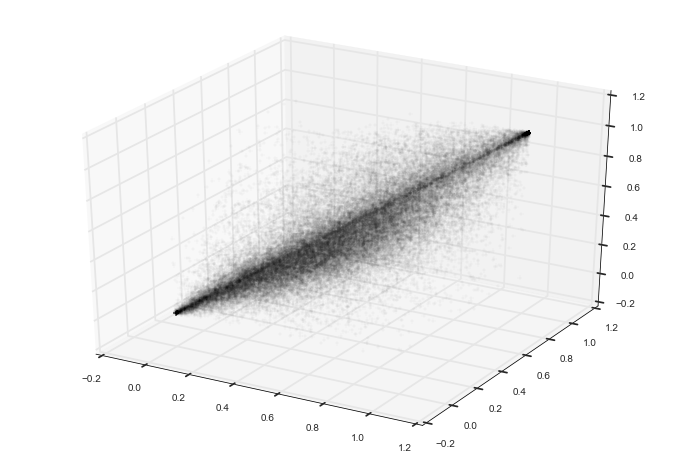

In [6]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples_rgb_subset[:,0], samples_rgb_subset[:,1], samples_rgb_subset[:,2],
           marker='+', alpha=0.1, color='black')

# Ideal distribution

The ideal distribution for training a neural networks.

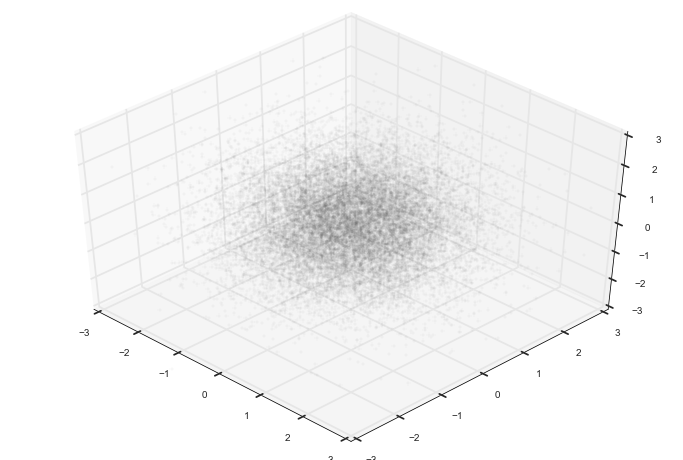

In [7]:
z_ideal = np.random.normal(size=(20000,3))

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_ideal[:,0], z_ideal[:,1], z_ideal[:,2],
           marker='+', alpha=0.1, color='black')

# Explicitly set the range that we are plotting to ensure uniform scale
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
ax.view_init(elev=45., azim=-45)

## Standardisation

The normal approach to standardisation will only help a little. Lets compute the mean and standard deviation and plot them over the scatter plot to show the distribution.

In [8]:
rgb_mean = np.mean(samples_rgb, axis=0)
rgb_std = np.std(samples_rgb, axis=0)
print 'Mean = {0}'.format(rgb_mean)
print 'Std-dev = {0}'.format(rgb_std)

Mean = [ 0.49139968  0.48215841  0.44653091]
Std-dev = [ 0.24703223  0.24348513  0.26158784]


There isn't much difference between the channels in terms of the mean and the standard deviation.

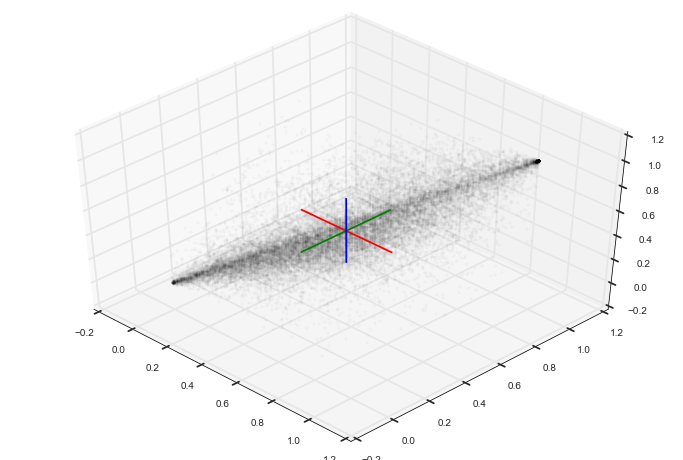

In [9]:
N = 20000

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples_rgb_subset[:N,0], samples_rgb_subset[:N,1], samples_rgb_subset[:N,2],
           marker='+', alpha=0.1, color='black')
ax.plot(np.array([rgb_mean[0]-rgb_std[0], rgb_mean[0]+rgb_std[0]]),
        np.array([rgb_mean[1], rgb_mean[1]]),
        np.array([rgb_mean[2], rgb_mean[2]]), color='red')

ax.plot(np.array([rgb_mean[0], rgb_mean[0]]),
        np.array([rgb_mean[1]-rgb_std[1], rgb_mean[1]+rgb_std[1]]),
        np.array([rgb_mean[2], rgb_mean[2]]), color='green')

ax.plot(np.array([rgb_mean[0], rgb_mean[0]]),
        np.array([rgb_mean[1], rgb_mean[1]]),
        np.array([rgb_mean[2]-rgb_std[2], rgb_mean[2]+rgb_std[2]]), color='blue')

ax.view_init(elev=45., azim=-45)


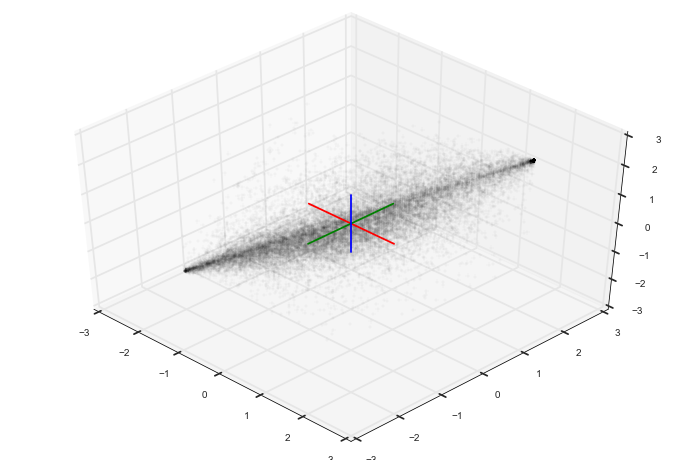

In [10]:
# Extract 5000 samples so that the scatter plot is not too dense
z = samples_rgb_subset[:N,:]

# Standardise
z_std = (z - rgb_mean) / rgb_std

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_std[:,0], z_std[:,1], z_std[:,2],
           marker='+', alpha=0.1, color='black')

# Create lines for unit standard deviation and plot them
r = np.array([[-1,0,0], [1,0,0]])
g = np.array([[0,-1,0], [0,1,0]])
b = np.array([[0,0,-1], [0,0,1]])
ax.plot(r[:,0], r[:,1], r[:,2], color='red')
ax.plot(g[:,0], g[:,1], g[:,2], color='green')
ax.plot(b[:,0], b[:,1], b[:,2], color='blue')

# Uniform plot scale
ax.set_xlim(-3.0, 3.0)
ax.set_ylim(-3.0, 3.0)
ax.set_zlim(-3.0, 3.0)
ax.view_init(elev=45., azim=-45)

A subset of the samples with the mean and standard deviation plotted; the mean as at the centre of the cross and the lines that pass through it extend 1 standard deviation to either side.

# PCA whitening

We can use PCA to extract the primary axes of variance and plot them. Note that we retain all axes; we do not use PCA to reduce dimensionality.

In [11]:
pca = PCA(n_components=3, whiten=True)
pca.fit(samples_rgb)

PCA(copy=True, n_components=3, whiten=True)

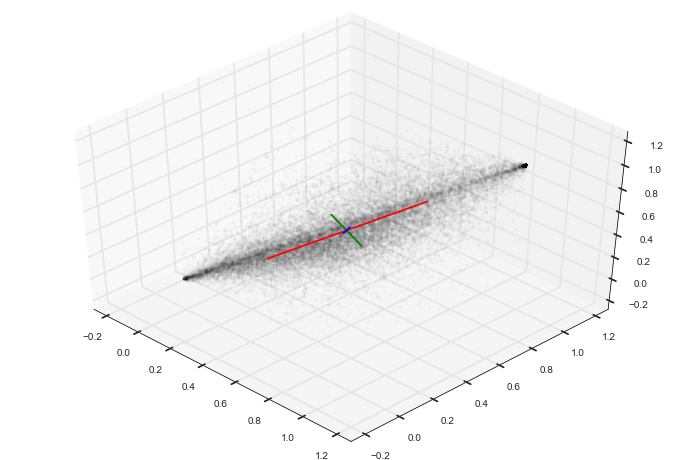

In [12]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z[:,0], z[:,1], z[:,2],
           marker='+', alpha=0.1, color='black')
# Get the mean and principal component axes and scale the axes by the standard deviation
mu = pca.mean_[None,:]
pc0 = pca.components_[0:1,:] * np.sqrt(pca.explained_variance_[0])
pc1 = pca.components_[1:2,:] * np.sqrt(pca.explained_variance_[1])
pc2 = pca.components_[2:3,:] * np.sqrt(pca.explained_variance_[2])

# Create the principal component lines
r = np.append(mu-pc0, mu+pc0, axis=0)
g = np.append(mu-pc1, mu+pc1, axis=0)
b = np.append(mu-pc2, mu+pc2, axis=0)

# Plot the principal components
ax.plot(r[:,0], r[:,1], r[:,2], color='red')
ax.plot(g[:,0], g[:,1], g[:,2], color='green')
ax.plot(b[:,0], b[:,1], b[:,2], color='blue')

ax.set_xlim(-0.25, 1.25)
ax.set_ylim(-0.25, 1.25)
ax.set_zlim(-0.25, 1.25)
ax.view_init(elev=45., azim=-45)

The samples with the principal components extracted by PCA.

### Rotate the samples onto the standard basis axes.

Use the PCA instance to rotate the samples onto the standard basis axes.

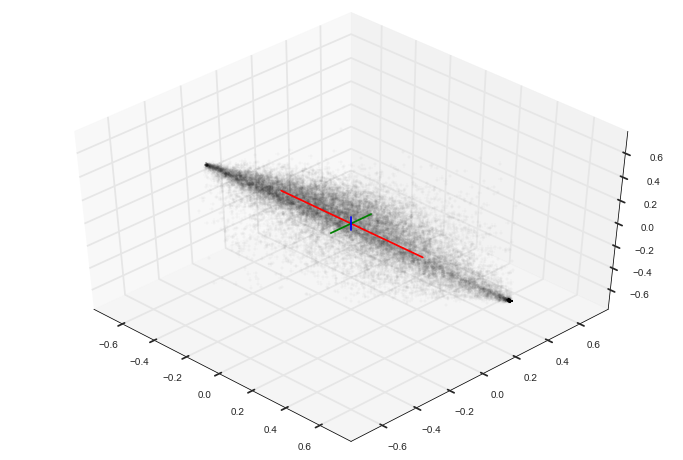

In [13]:
# Turn whitening off temporarily so that we don't scale the samples yet.
pca.whiten = False
z_basis = pca.transform(z)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_basis[:,0], z_basis[:,1], z_basis[:,2],
           marker='+', alpha=0.1, color='black')
# Get the mean and principal component axes and scale the axes by the standard deviation
# The mean is now at 0,0,0 since PCA will have subtracted it from each sample, moving
# the mean there
mu = np.array([[0,0,0]])
# The principal components have now been rotated onto the standard basis axes.
# Scale by the standard deviation.
pc0 = np.array([[1,0,0]]) * np.sqrt(pca.explained_variance_[0])
pc1 = np.array([[0,1,0]]) * np.sqrt(pca.explained_variance_[1])
pc2 = np.array([[0,0,1]]) * np.sqrt(pca.explained_variance_[2])

# Create the principal component lines
r = np.append(mu-pc0, mu+pc0, axis=0)
g = np.append(mu-pc1, mu+pc1, axis=0)
b = np.append(mu-pc2, mu+pc2, axis=0)

# Plot the principal components
ax.plot(r[:,0], r[:,1], r[:,2], color='red')
ax.plot(g[:,0], g[:,1], g[:,2], color='green')
ax.plot(b[:,0], b[:,1], b[:,2], color='blue')

# Explicitly set the range that we are plotting to ensure uniform scale
ax.set_xlim(-0.75, 0.75)
ax.set_ylim(-0.75, 0.75)
ax.set_zlim(-0.75, 0.75)
ax.view_init(elev=45., azim=-45)

The samples are primarily aligned along the X-axis.

### Full PCA whitening

PCA whitening adds one final step; after rotating the samples so that the principal components are aligned with the standard basis axes, the samples are scaled by the reciprocal of the standard deviation so that the distribution has unit variance.

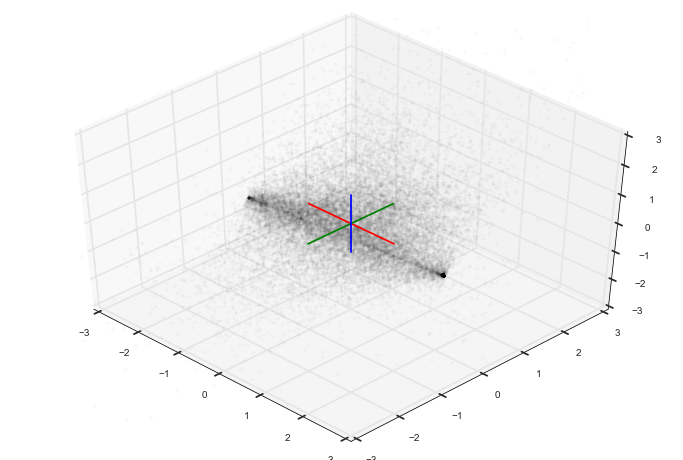

In [14]:
# Turn whitening back on.
pca.whiten = True
z_whitened = pca.transform(z)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_whitened[:,0], z_whitened[:,1], z_whitened[:,2],
           marker='+', alpha=0.1, color='black')
# Get the mean and principal component axes and scale the axes by the standard deviation
mu = np.array([[0,0,0]])
pc0 = np.array([[1,0,0]])
pc1 = np.array([[0,1,0]])
pc2 = np.array([[0,0,1]])

# Create the principal component lines
r = np.append(mu-pc0, mu+pc0, axis=0)
g = np.append(mu-pc1, mu+pc1, axis=0)
b = np.append(mu-pc2, mu+pc2, axis=0)

# Plot the principal components
ax.plot(r[:,0], r[:,1], r[:,2], color='red')
ax.plot(g[:,0], g[:,1], g[:,2], color='green')
ax.plot(b[:,0], b[:,1], b[:,2], color='blue')

# Explicitly set the range that we are plotting to ensure uniform scale
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
ax.view_init(elev=45., azim=-45)